# Homework 3: Sampling
- Name: Congxin (David) Xu
- Computing ID: cx2rx

### Honor Pledge: 
I have neither given nor received aid on this assignment.

### Problem 1
(10) Suppose whether it is sunny or not in Charlottesville depends on the
weather of the last three days. Show how this can be modeled as a Markov
chain.

|   Last Three Days|   Sunny (S)|   Not Sunny (N)|
|:-                | ---        |---           |
|       SSS     |   P(SSSS)     |   P(SSSN)       |
|       NSS     |   P(NSSS)    |   P(NSSN)       |
|           SNS    |   P(SNSS)    |   P(SNSN)        |
|           SNS    |   P(SNSS)   |   P(SNSN)       |
|           NNS    |   P(NNSS)   |   P(NNSN)       |
|           NSN    |   P(NSNS)   |   P(NSNN)        |
|           SNN    |   P(SNNS)   |   P(SNNN)        |
|           NNN    |   P(NNNS)   |   P(NNNN)       |

The probability of Sunny or Not Sunny in Charlottesville can be looked up in the table above. 

### Problem 2
Let $X \sim N(\mu, \Sigma)$ where $\mu = (1, 1)$ and
$$ \Sigma = \begin{bmatrix}
1 & -0.5 \\ 
-0.5 & 1 
\end{bmatrix}
$$
Use numpy and scipy to implement a Gibbs sampling algorithm for this
2D Gaussian. Show three runs of you algorithm with 100 samples past
burn-in as 1D scatter plots in each of the two dimensions overlaid on the
plots of the actual marginal distributions.

#### Reference: 
https://jessicastringham.net/2018/05/09/gibbs-sampling/

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

In [2]:
# set up the means
a_mu = 0
b_mu = 0

a_sigma = 1
b_sigma = 1
a_b_cov = -0.5

joint_cov = np.vstack(((a_sigma, a_b_cov), (a_b_cov, b_sigma)))
joint_mu = np.vstack((a_mu, b_mu))

In [3]:
N = 10000

L = np.linalg.cholesky(joint_cov)
samples_from_true_distribution =  L @ np.random.randn(2, N) + joint_mu

In [4]:
def get_conditional_dist(joint_mu, joint_cov, var_index):
    '''Returns the conditional distribution given the joint distribution and which variable
    the conditional probability should use.
    Right now this only works for 2-variable joint distributions.
    
      joint_mu: joint distribution's mu
      joint_cov: joint distribution's covariance
      var_index: index of the variable in the joint distribution. Everything else will be 
        conditioned on. For example, if the joint distribution p(a, b, c) has mu [mu_a, mu_b, mu_c],
        to get p(c | a, b), use var_index = 2.
      
    returns:
      a function that can sample from the univariate conditional distribution
    '''
    assert joint_mu.shape[0] == 2, 'Sorry, this function only works for 2-dimensional joint distributions right now'
    a = joint_mu[var_index]
    b = joint_mu[~var_index]
    
    A = joint_cov[var_index, var_index]
    B = joint_cov[~var_index, ~var_index]
    C = joint_cov[var_index, ~var_index]
    
    # we're dealing with one dimension so
    B_inv = 1/B
    
    # Return a function that can sample given a value of g
    def dist(g):
        # a + C*B^{-1}(g - b)
        mu = a + C * B_inv * (g - b)
        # A - C * B^{-1} * C^T
        cov = A - B_inv * C * C
        return np.sqrt(cov) * np.random.randn(1) + mu
    
    return dist

In [5]:
def gibbs_sample(univariate_conditionals, sample_count):
    '''Does Gibbs sampling given the distribution's univariate conditionals.
    
    Returns a D x N matrix
    '''
    D = len(univariate_conditionals)
    assert D == 2, "Sorry, this only supports 2 dimensions right now"
    
    # initializes an empty matrix for the samples
    samples = np.zeros((D, sample_count))

    # initialize the first sample to some arbitrary value
    samples[:, 0] = [3, -3]
    
    for i in range(1, sample_count):
        # first set this sample equal to the previous sample
        samples[:, i] = samples[:, i - 1]
        
        # now update the dimension whose turn it is using the conditional distribution
        # pass in all dimension from the previous sample except this dimension
        d = i % D
        samples[d, i] = univariate_conditionals[d](samples[~d, i - 1])
                 
    return samples

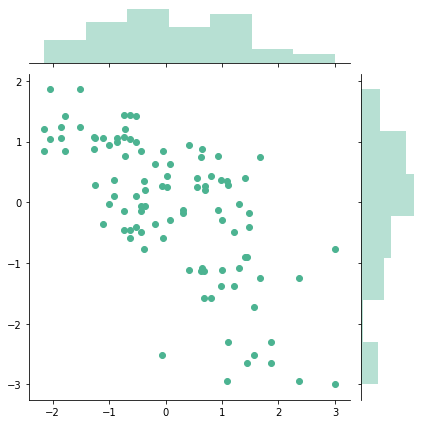

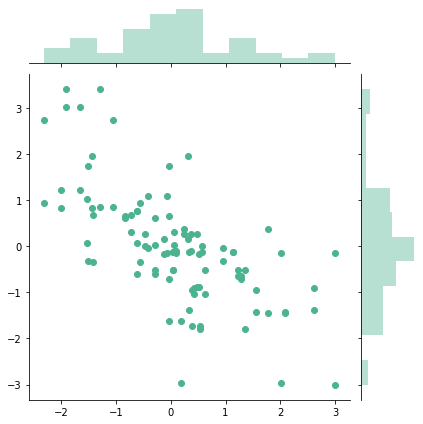

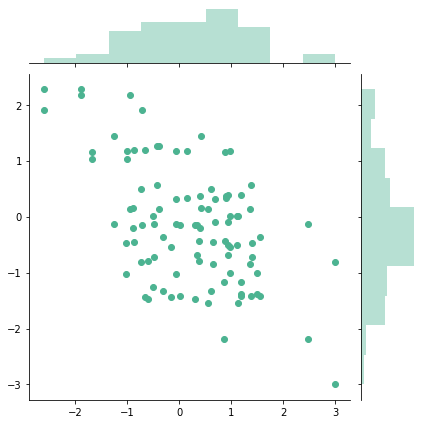

In [6]:
for i in range(3):
    univariate_conditionals = [get_conditional_dist(joint_mu, joint_cov, d) for d in range(2)]
    samples = gibbs_sample(univariate_conditionals, sample_count=100)
    sns.jointplot(samples[0], samples[1], kind="scatter", color="#4CB391")

### Problem 3

(25) With the CHD data set (`CHDdata.csv`) from Homework 2 develop a
sampling based estimate for the posterior distributions of the parameters
in a main effects logistic regression model. Use all predictor variables
in the data set and standardize all of the numeric, continuous predictors
using the mean and standard deviation.

- Use Gaussian or Cauchy priors with hyperparameters appropriate for uninformed priors and show the graphical representation of your model (you should use graphviz for this).
- Show the summary table and trace plots from the sampling and briefly say what they mean for your results.
- Provide forest plots of the parameters and discuss what these results imply for the relevant predictor variables and the overall model.

In [7]:
data = pd.read_csv('CHDdata.csv')
data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [8]:
# Standardize all numeric variables
tmp = data[['famhist']].astype('category')
tmp["famhist"] = tmp["famhist"].cat.codes.values
tmp2 = data[['chd']]

data = data.drop('famhist', axis = 1)
data = data.drop('chd', axis = 1)

normalized_data=(data-data.mean())/data.std()
normalized_data = pd.concat([tmp,  
                             normalized_data.reset_index(drop=True),], 
                            axis=1)

normalized_data = pd.concat([tmp2,  
                             normalized_data.reset_index(drop=True),], 
                            axis=1)

normalized_data.head()

,chd,famhist,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age
0,1,1,1.057417,1.821099,0.477894,-0.295183,-0.418017,-0.176594,3.274189,0.628654
1,1,0,0.276789,-0.789382,-0.159507,0.411694,0.193134,0.670646,-0.612081,1.381617
2,0,1,-0.991731,-0.774141,-0.608585,0.883374,-0.112441,0.734723,-0.540597,0.217947
3,1,1,1.545310,0.841352,0.806252,1.622382,-0.214300,1.411091,0.294742,1.039361
4,1,1,-0.211103,2.169453,-0.598928,0.305020,0.702427,-0.012842,1.645991,0.423301


In [9]:
practitioner_idx = normalized_data.famhist.astype('category').cat.codes.values

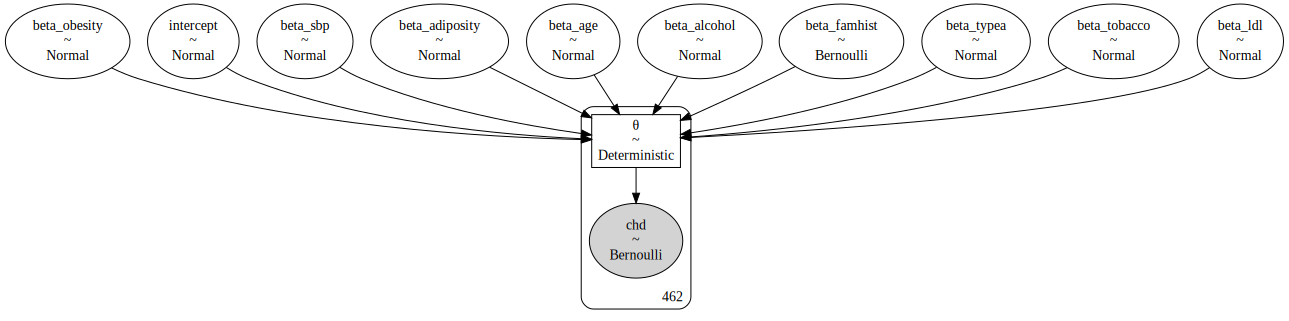

In [10]:
with pm.Model() as manual_logistic_model:
    
    # coefficients
    intercept = pm.Normal('intercept', mu=0, sd=100) 
    beta_famhist = pm.Bernoulli('beta_famhist', p = 0.5)
    beta_sbp = pm.Normal('beta_sbp', mu=0, sd=100) 
    beta_tobacco = pm.Normal('beta_tobacco', mu=0, sd=100)
    beta_ldl = pm.Normal('beta_ldl', mu=0, sd=100)
    beta_adiposity = pm.Normal('beta_adiposity', mu=0, sd=100)
    beta_typea = pm.Normal('beta_typea', mu=0, sd=100)
    beta_obesity = pm.Normal('beta_obesity', mu=0, sd=100)
    beta_alcohol = pm.Normal('beta_alcohol', mu=0, sd=100)
    beta_age = pm.Normal('beta_age', mu=0, sd=100)

    
    μ = intercept + \
        pm.math.dot(normalized_data["famhist"], beta_famhist) + \
        pm.math.dot(normalized_data["sbp"], beta_sbp) + \
        pm.math.dot(normalized_data["tobacco"], beta_tobacco) + \
        pm.math.dot(normalized_data["ldl"], beta_ldl) + \
        pm.math.dot(normalized_data["adiposity"], beta_adiposity) + \
        pm.math.dot(normalized_data["typea"], beta_typea) + \
        pm.math.dot(normalized_data["obesity"], beta_obesity) + \
        pm.math.dot(normalized_data["alcohol"], beta_alcohol) + \
        pm.math.dot(normalized_data["age"], beta_age)
    
    θ = pm.Deterministic('θ', pm.invlogit(μ))
        
    y = pm.Bernoulli('chd',
                     θ[practitioner_idx], 
                     observed=normalized_data.chd)    

pm.model_to_graphviz(manual_logistic_model)

In [11]:
with pm.Model() as logistic_model_all:
    Y = normalized_data['chd']
    pm.glm.GLM.from_formula('Y ~ famhist+sbp+tobacco+ldl+adiposity+typea+obesity+alcohol+age',
                            data = normalized_data, family = pm.glm.families.Binomial())
    trace_all = pm.sample(1000, tune = 1000, init = 'adapt_diag', cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, alcohol, obesity, typea, adiposity, ldl, tobacco, sbp, famhist, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


In [12]:
az.summary(trace_all, round_to=2)

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.29,0.17,-1.63,-1.00,0.0,0.0,3487.95,3458.09,3505.35,3059.10,1.0
famhist,0.95,0.23,0.53,1.40,0.0,0.0,3613.27,3533.85,3623.83,2987.01,1.0
sbp,0.14,0.12,-0.08,0.35,0.0,0.0,5764.27,3557.48,5805.90,2882.11,1.0
tobacco,0.38,0.12,0.15,0.61,0.0,0.0,5700.47,4756.25,5838.09,3022.90,1.0
ldl,0.37,0.13,0.13,0.61,0.0,0.0,5967.17,5330.90,5875.36,2807.22,1.0
adiposity,0.15,0.23,-0.26,0.61,0.0,0.0,3667.54,2206.68,3663.68,2909.18,1.0
typea,0.40,0.12,0.17,0.63,0.0,0.0,5615.72,5011.27,5651.47,2663.77,1.0
obesity,-0.28,0.19,-0.63,0.09,0.0,0.0,3863.12,2990.42,3867.64,2950.65,1.0
alcohol,0.00,0.11,-0.19,0.22,0.0,0.0,5991.21,2004.93,5979.52,3188.62,1.0
age,0.68,0.18,0.34,1.00,0.0,0.0,3907.93,3746.11,3901.10,2908.51,1.0


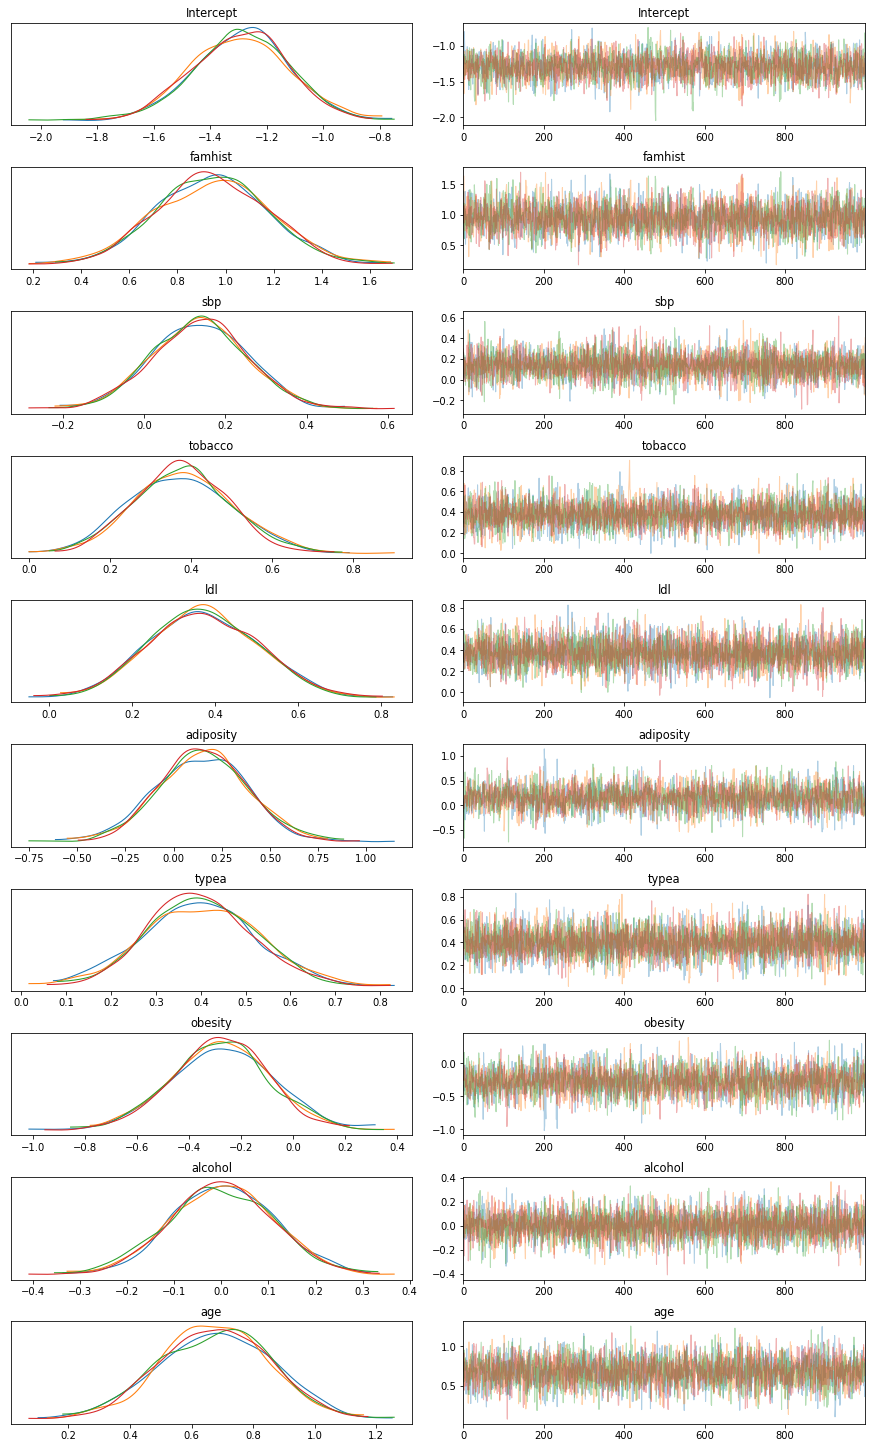

In [13]:
with pm.Model() as logistic:
    az.plot_trace(trace_all)

From the summary table and trace plot, we can see that all predictors and intercept quickly converges and all 4 cores have the same distribution for each individual predictor.

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<Figure size 432x1008 with 0 Axes>

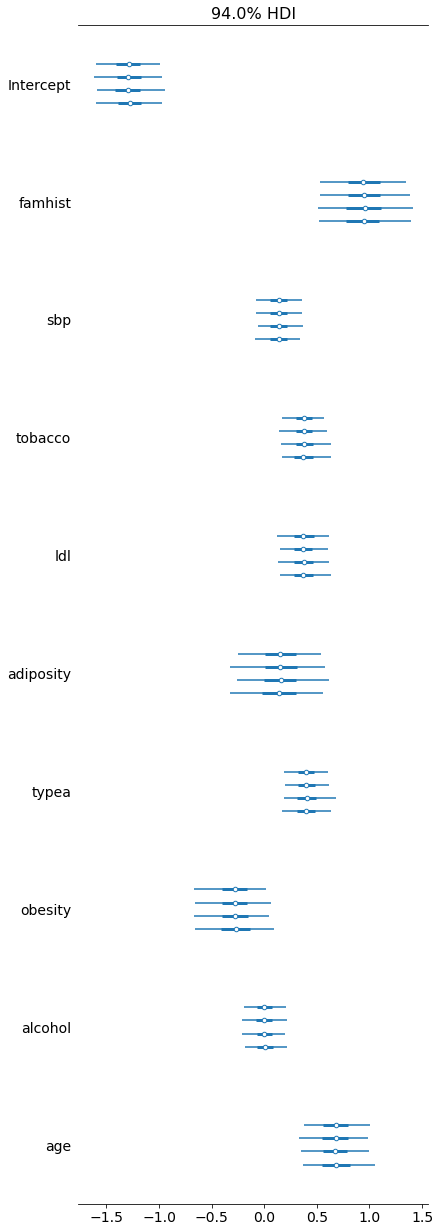

In [14]:
plt.figure(figsize=(6,14))
pm.forestplot(trace_all);

Based on the forest plot, we can see that for predictors `sbp`, `adiposity`, `obesity` and `alcohol`, their 94% confidence interval of the coefficients covers the value of 0. Therefore, we can conclude that those predictors may be removed from the model.

### Problem 4
(20) With the data set `bangladesh.csv` develop a pooled, a no-pooled, and
a hierarchical model for all districts to predict `contraception usage`. Use
only `district` and `age.centered` as predictor variables. Plot each of these
predictions with `age.centered` on the x-axis and the expected proportion
of women `using contraception` on the y-Axis with overlaid plots for the
districts. Briefly explain these results.

In [15]:
data = pd.read_csv('bangladesh.csv')
data.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


In [16]:
# data preprocessing
data.district = data.district.astype(str).map(str.strip)
mn_district = data.district.unique()
districts = len(mn_district)
district_lookup = dict(zip(mn_district, range(len(mn_district))))
district = data['district'] = data.district.replace(district_lookup).values

data = data.rename(columns={'use.contraception': 'use_contraception',
                        'age.centered': 'age_centered'})

use = data.use_contraception
age = data.age_centered

In [17]:
# pooled model
with pm.Model() as pooled_model:

    beta0 = pm.Normal('beta0', 0, sd=1e3)
    beta1 = pm.Normal('beta1', 0, sd=1e3)

    theta = 1 / (1 + np.exp(beta0 + beta1*age))

    y = pm.Bernoulli('y', p = theta, observed=use)
    
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag', target_accept=0.99, cores = 4)
    
    pooled_idata = az.from_pymc3(trace)
    
az.summary(pooled_idata, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,0.44,0.05,0.35,0.52,0.0,0.0,2238.65,2238.65,2246.15,1953.44,1.0
beta1,-0.01,0.01,-0.02,0.00,0.0,0.0,2104.80,1741.68,2137.76,1661.89,1.0


In [18]:
coeff = az.summary(pooled_idata, round_to=2)[['mean']]
coeff

,mean
beta0,0.44
beta1,-0.01


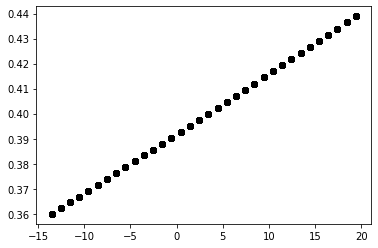

In [19]:
X = data[['age_centered']]
X.insert(0, 'Intercept', 1)
# Calculated the Predicted Probabilities
X.insert(0, 
         'predicted', 
         1 / (1 + np.exp(np.matmul(X.to_numpy(), coeff.to_numpy()))))
plt.plot(X.age_centered, X.predicted, 'o', color='black');

For the pooled model, we only generated 1 model for all district. As the age increases, we can see that the use of contraception also increases.

In [20]:
with pm.Model() as unpooled_model:

    beta0 = pm.Normal('beta0', 0, sd=100, shape=districts)
    beta1 = pm.Normal('beta1', 0, sd=100, shape=districts)
    
    # Model error
    sigma = pm.HalfCauchy('sigma', 5)
    
    # Expected value
    y_hat = beta0[district] +  beta1[district] * age
    
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma, observed=use)
    
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag', target_accept=0.99, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


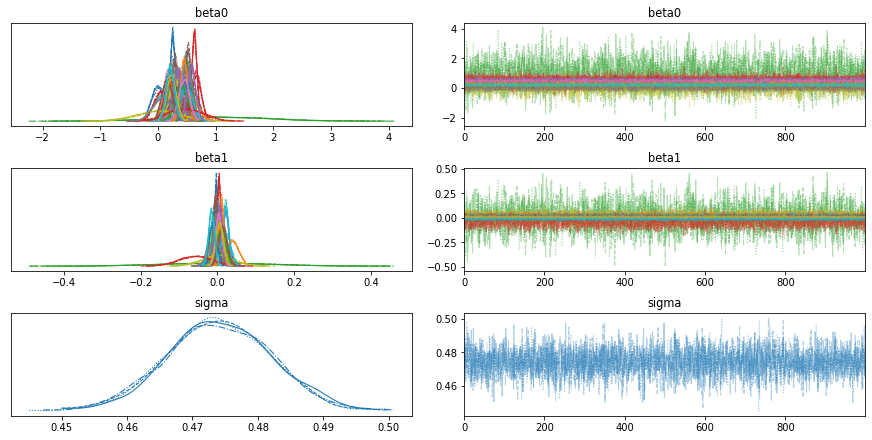

In [21]:
pm.traceplot(trace);

In [22]:
az.summary(az.from_pymc3(trace))

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[0],0.258,0.044,0.179,0.346,0.001,0.000,4375.0,4310.0,4363.0,2600.0,1.0
beta0[1],0.368,0.110,0.163,0.574,0.002,0.001,4706.0,4579.0,4712.0,2778.0,1.0
beta0[2],0.990,0.905,-0.835,2.558,0.019,0.013,2320.0,2286.0,2317.0,2761.0,1.0
beta0[3],0.503,0.089,0.336,0.670,0.001,0.001,4473.0,4394.0,4463.0,2990.0,1.0
beta0[4],0.355,0.075,0.221,0.500,0.001,0.001,5146.0,5054.0,5161.0,3039.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta1[56],0.003,0.008,-0.013,0.018,0.000,0.000,4388.0,2452.0,4374.0,3245.0,1.0
beta1[57],-0.006,0.017,-0.037,0.026,0.000,0.000,3322.0,2404.0,3313.0,2869.0,1.0
beta1[58],0.005,0.010,-0.014,0.023,0.000,0.000,4036.0,2548.0,4040.0,2959.0,1.0
beta1[59],-0.015,0.008,-0.030,-0.002,0.000,0.000,4935.0,4401.0,4935.0,3311.0,1.0


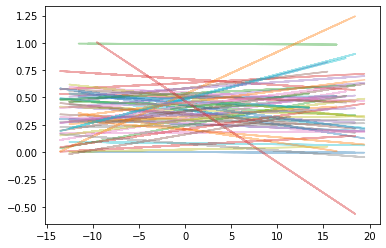

In [23]:
beta_county = pd.Series(trace['beta0'].mean(axis=0), index=mn_district)
beta_age = pd.Series(trace['beta1'].mean(axis=0), index=mn_district)

for i in mn_district:
    coeff = pd.DataFrame({beta_county[i], beta_age[i]})
    tmp = data[district == int(i)][['age_centered']]
    tmp.insert(0,'intercept', 1)
    tmp.insert(0,'predicted', np.matmul(tmp.to_numpy(), coeff.to_numpy()))
    plt.plot(tmp.age_centered, tmp.predicted, '-', alpha=0.4);

We can see that almost all of the districts have the same posterior distribution except only 1 district. After reviewing the raw data, I found that district has a lot of `NAs` and therefore throw off the results.

In [24]:
# Hierarchical Model
with pm.Model() as varying_intercept_slope:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    sigma_b = pm.Exponential("sigma_b", .5)

    # Random intercepts
    beta0 = pm.Normal('beta0', mu=mu_a, sd=sigma_a, shape=districts)
    # Random slopes
    beta1 = pm.Normal('beta1', mu=mu_b, sd=sigma_b, shape=districts)

    # Model error
    sigma = pm.HalfCauchy('sigma', 5)

    y_hat = beta0[district] +  beta1[district] * age
    
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma, observed=use)
    
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag', target_accept=0.99, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 198 seconds.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8748650986174957, but should be close to 0.99. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9710225042950842, but should be close to 0.99. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


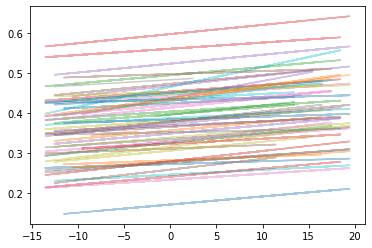

In [25]:
beta_county = pd.Series(trace['beta0'].mean(axis=0), index=mn_district)
beta_age = pd.Series(trace['beta1'].mean(axis=0), index=mn_district)

for i in mn_district:
    coeff = pd.DataFrame({beta_county[i], beta_age[i]})
    coeff.shape
    tmp = data[district == int(i)][['age_centered']]
    tmp.insert(0,'intercept', 1)
    tmp.insert(0,'predicted', np.matmul(tmp.to_numpy(), coeff.to_numpy()))
    plt.plot(tmp.age_centered, tmp.predicted, '-', alpha=0.4);

We can see that most of the districts have a positive coefficient for age, which also matches our finding in the pooled model. 

### Problem 5
(25) For the CHD data in problem 3, develop two other models with fewer
predictor variables and/or with a nonlinear transformation of one of the
the predictor variables.

- Use WAIC to recommend which of these models to use.
- Use WAIC to produce a Bayesian model average result. Show the kernel density plots for the sample posterior predictions of each of the models and the Bayesian model average.
- (5 points extra credit) Show the overlaid plots of the predictions for the data points in the `CHDdata.csv` file with age on the x-axis and the predicted probability on the y-axis. Overlay these results for each model and for the Bayesian model average of the models.

In [26]:
normalized_data.head()

,chd,famhist,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age
0,1,1,1.057417,1.821099,0.477894,-0.295183,-0.418017,-0.176594,3.274189,0.628654
1,1,0,0.276789,-0.789382,-0.159507,0.411694,0.193134,0.670646,-0.612081,1.381617
2,0,1,-0.991731,-0.774141,-0.608585,0.883374,-0.112441,0.734723,-0.540597,0.217947
3,1,1,1.545310,0.841352,0.806252,1.622382,-0.214300,1.411091,0.294742,1.039361
4,1,1,-0.211103,2.169453,-0.598928,0.305020,0.702427,-0.012842,1.645991,0.423301


In [27]:
# Model 1 chd ~ tobacco + typea + age
with pm.Model() as logistic_model_1:
    pm.glm.GLM.from_formula('chd ~ tobacco+typea+age',
                            data = normalized_data, family = pm.glm.families.Binomial())
    trace1 = pm.sample(1000, tune = 1000, init = 'adapt_diag', cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, typea, tobacco, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


In [28]:
# Model 2 chd ~ tobacco + tobacco^2 + typea + log(age)
normalized_data.insert(0, 'tobacco_sq', normalized_data.tobacco**2)

In [29]:
# Model 2 chd ~ tobacco + tobacco^2 + typea
with pm.Model() as logistic_model_2:
    Y = normalized_data['chd']
    pm.glm.GLM.from_formula('Y ~ tobacco+tobacco_sq+typea+age',
                            data = normalized_data, family = pm.glm.families.Binomial())
    trace2 = pm.sample(1000, tune = 1000, init = 'adapt_diag', cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, typea, tobacco_sq, tobacco, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


In [30]:
model_dict = dict(zip([logistic_model_all, logistic_model_1, logistic_model_2], 
                      [trace_all, trace1, trace2]))
comp = pd.DataFrame(pm.compare(model_dict, ic = 'WAIC', method='BB-pseudo-BMA'))
comp.reset_index(inplace = True)
comp

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  F

,index,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
0,<pymc3.model.Model object at 0x00000286B6789988>,0,-246.365,10.258,0,0.913901,11.1786,0,False,log
1,<pymc3.model.Model object at 0x00000286BB982E08>,1,-255.732,4.01115,9.36669,0.0580572,9.65568,5.89954,False,log
2,<pymc3.model.Model object at 0x00000286BB833308>,2,-256.461,4.67611,10.0961,0.028042,9.69294,5.88611,False,log


In [31]:
traces = [trace_all, trace1, trace2]
ppc_w = pm.sample_posterior_predictive_w(traces, 1000, 
                                         [logistic_model_all, logistic_model_1, logistic_model_2],
                        weights=comp.weight.sort_index(ascending=True))

In [32]:
y_full = pm.sample_posterior_predictive_w(traces = [trace_all],
                                          samples=1000,
                                          models=[logistic_model_all])
y_model_1 = pm.sample_posterior_predictive_w(traces = [trace1],
                                          samples=1000,
                                          models=[logistic_model_1])
y_model_2 = pm.sample_posterior_predictive_w(traces = [trace1],
                                          samples=1000,
                                          models=[logistic_model_1])


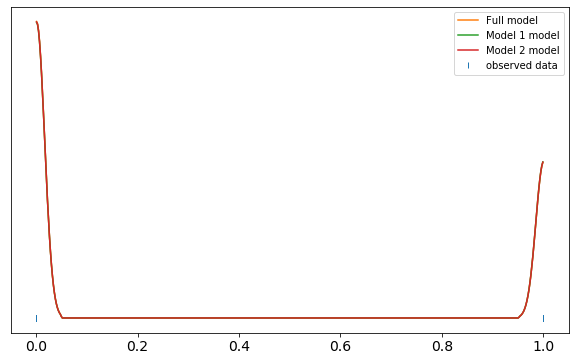

In [33]:
# Kernel Density Plot
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_full['y'], plot_kwargs={'color': 'C1'}, label='Full model', ax=ax)
az.plot_kde(y_model_1['y'], plot_kwargs={'color': 'C2'}, label='Model 1 model', ax=ax)
az.plot_kde(y_model_2['y'], plot_kwargs={'color': 'C3'}, label='Model 2 model', ax=ax)

plt.plot(normalized_data['chd'], np.zeros_like(normalized_data['chd']), '|', label='observed data')
plt.yticks([])
plt.legend();

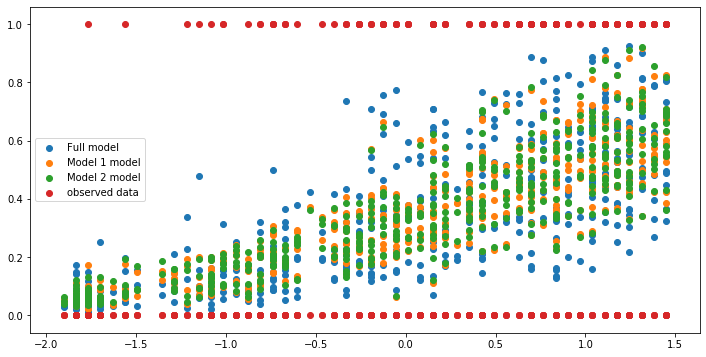

In [34]:
plt.figure(figsize = (12, 6))
plt.scatter(normalized_data['age'], np.mean(y_full['y'], axis = 0), label='Full model')
plt.scatter(normalized_data['age'], np.mean(y_model_1['y'], axis = 0), label='Model 1 model')
plt.scatter(normalized_data['age'], np.mean(y_model_2['y'], axis = 0),  label='Model 2 model')
plt.scatter(normalized_data['age'], normalized_data['chd'], label='observed data')
plt.legend();